In [4]:
import pandas as pd
import numpy as np

### 1. Data Preperation

The data is retrieved from Kaggle: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

The target variable is "is_canceled" ('1' = Yes, '0' = No). Features include order details, booking histories, etc.

This is an application of DT in classification problem.

In [5]:
df_booking = pd.read_csv("/Users/bl/Desktop/hotel_bookings.csv")

df_booking = df_booking[['is_canceled', 'hotel', 'lead_time', 'arrival_date_month', 'stays_in_weekend_nights',
                         'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country',
                         'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
                         'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type',
                         'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type',
                         'adr', 'required_car_parking_spaces', 'total_of_special_requests']]

# create new features
df_booking['dependents'] = df_booking['children'] + df_booking['babies']
df_booking['total_cancel'] = (df_booking['previous_cancellations'] + df_booking['previous_bookings_not_canceled'])
df_booking['cancel_pct'] = np.where(df_booking['total_cancel'] == 0, 0,
                                    df_booking['previous_cancellations']/df_booking['total_cancel'])

df_booking['desired_room_type'] = np.where(df_booking['reserved_room_type'] == df_booking['assigned_room_type'], 1, 0)

# drop original features above
df_booking = df_booking.drop(columns  = ['children', 'babies',
                                         'previous_cancellations', 'previous_bookings_not_canceled', 'total_cancel', 'reserved_room_type', 'assigned_room_type' ])

# regroup categorical variables based on the data dictionary on Kaggle
df_booking['country'] = np.where(df_booking['country'].isin(['PRT', 'GBR']), df_booking['country'], 'Other')
df_booking['distribution_channel'] = np.where(df_booking['distribution_channel'].isin(['TA/TO', 'Direct']),
                                              df_booking['distribution_channel'], 'Other')

df_booking['meal'] = np.where(df_booking['meal'].isin(['BB', 'HB']), df_booking['meal'], 'Other')

df_booking['customer_type'] = np.where(df_booking['customer_type'].isin(['Contract', 'Group']), 'Other',
                                       df_booking['customer_type'] )

# change some columns to string/object
cat_col = [ 'is_repeated_guest', 'desired_room_type']
df_booking[cat_col] = df_booking[cat_col].astype('str')

print(df_booking.shape)
df_booking.head()

(119390, 21)


,is_canceled,hotel,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,distribution_channel,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,dependents,cancel_pct,desired_room_type
0,0,Resort Hotel,342,July,0,0,2,BB,PRT,Direct,...,3,No Deposit,0,Transient,0.0,0,0,0.0,0.0,1
1,0,Resort Hotel,737,July,0,0,2,BB,PRT,Direct,...,4,No Deposit,0,Transient,0.0,0,0,0.0,0.0,1
2,0,Resort Hotel,7,July,0,1,1,BB,GBR,Direct,...,0,No Deposit,0,Transient,75.0,0,0,0.0,0.0,0
3,0,Resort Hotel,13,July,0,1,1,BB,GBR,Other,...,0,No Deposit,0,Transient,75.0,0,0,0.0,0.0,1
4,0,Resort Hotel,14,July,0,2,2,BB,GBR,TA/TO,...,0,No Deposit,0,Transient,98.0,0,1,0.0,0.0,1


#### 2. Feature Engineering

##### 2.1 Training and Test Sets Split

In [6]:
from sklearn.model_selection import train_test_split

random_state = 20250910

X_train, X_test, y_train, y_test = train_test_split(
    df_booking.drop(columns = 'is_canceled'),
    df_booking['is_canceled'],
    test_size = 0.3,
    random_state = random_state,
    stratify = df_booking['is_canceled'] # imbalance
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(83573, 20) (35817, 20) (83573,) (35817,)


##### 2.2 Scaling
1. Use training set to fit the scaler
2. Apply the same scaler fitted with training set to test set

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Identify categorical and numeric columns
## numeric variables scaled to [0,1]
num_cols = X_train.select_dtypes(include = ["int64", "float64"]).columns
## categorical variables: one-hot coding
cat_cols = X_train.select_dtypes(include = ["object"]).columns

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),  # scale numeric columns
        ("cat", OneHotEncoder(handle_unknown = "ignore", sparse_output = False), cat_cols)  # one-hot encode categorical
    ]
)

# 3. Fit on training data, transform both train and test
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

# 4. Recover feature names
feature_names = preprocessor.get_feature_names_out()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=feature_names, index=X_test.index)

X_test_scaled.head()

,num__lead_time,num__stays_in_weekend_nights,num__stays_in_week_nights,num__adults,num__booking_changes,num__days_in_waiting_list,num__adr,num__required_car_parking_spaces,num__total_of_special_requests,num__dependents,...,cat__is_repeated_guest_0,cat__is_repeated_guest_1,cat__deposit_type_No Deposit,cat__deposit_type_Non Refund,cat__deposit_type_Refundable,cat__customer_type_Other,cat__customer_type_Transient,cat__customer_type_Transient-Party,cat__desired_room_type_0,cat__desired_room_type_1
102561,-0.974316,-0.929487,-0.787130,0.245397,-0.339241,-0.131962,-0.600999,-0.254049,0.541396,-0.273229,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20024,-0.974316,-0.929487,-0.787130,0.245397,-0.339241,-0.131962,-1.327414,-0.254049,-0.719398,-0.273229,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
80667,-0.675092,-0.929487,-0.264110,-1.480768,-0.339241,-0.131962,-0.600999,-0.254049,-0.719398,-0.273229,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11403,1.138957,1.071622,1.304949,0.245397,-0.339241,-0.131962,0.162774,-0.254049,-0.719398,-0.273229,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
21723,-0.974316,-0.929487,-0.787130,-1.480768,-0.339241,-0.131962,-1.285905,-0.254049,-0.719398,-0.273229,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### 3. Model Fitting
1. StratifiedShuffleSplit
- Stratified: each split keeps (approximately) the same class distribution as y
- Shuffle: it randomly shuffles before splitting.
- Split: you can generate multiple independent splits (controlled by n_splits) to average results. (can be repeated)
2. Error Metrics
For imbalanced datasets, the following metrics are more helpful to analyze model performance
- Precision
    - TP/(TP+FP)
    - measures True Positives in all Pred Positives
    - cares about being right when you say “positive"
- Recall
    - TP/(TP+FN)
    - measures True Positives in all Actual Positives
    - cares about catching as many as true
- F1
    - 2(precision*recall)/(precision+recall)
- PR AUC
    - Area Under the Precision–Recall curve. It summarizes how well a binary classifier ranks positives above negatives across all score thresholds—especially useful on imbalanced data.
    - “Rank positives above negatives” means when your model assigns a score to each example (e.g., a probability or margin), true positives should, on average, get higher scores than true negatives. If you sort all examples by the model’s score from highest → lowest, you’d like most of the top items to be real positives.
    - PR curves and AP/PR-AUC evaluate the model as you vary the decision threshold. Models that consistently give higher scores to positives will achieve high precision at many recall levels, producing a better PR curve (and higher AP)


##### 3.1 Model and Hyperparameter Tuning

In [12]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score,  classification_report

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = random_state)

dt_classifier = DecisionTreeClassifier(random_state=random_state)

param_grid = {
                "max_depth": [6, 10, 14, 18],
                "min_samples_leaf": [50, 100, 200],
                "min_samples_split": [100, 200, 400],
                "max_features": ["sqrt", "log2", 0.5],          #
                "ccp_alpha": [0.0, 0.0001, 0.0005, 0.003],
                "criterion": ["gini", "entropy"],
                "class_weight": ['balanced']
            }

search = HalvingGridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    factor=3,
    resource="n_samples",
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train_scaled, y_train)
print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)

best_dt = search.best_estimator_
y_pred = best_dt.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print('PR AUC: ', average_precision_score(y_test, y_pred))

y_prob = best_dt.predict_proba(X_test_scaled)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification report:\n", classification_report(y_test, y_pred))

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 114
max_resources_: 83573
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 864
n_resources: 114
Fitting 3 folds for each of 864 candidates, totalling 2592 fits
----------
iter: 1
n_candidates: 288
n_resources: 342
Fitting 3 folds for each of 288 candidates, totalling 864 fits
----------
iter: 2
n_candidates: 96
n_resources: 1026
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 3
n_candidates: 32
n_resources: 3078
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 4
n_candidates: 11
n_resources: 9234
Fitting 3 folds for each of 11 candidates, totalling 33 fits
----------
iter: 5
n_candidates: 4
n_resources: 27702
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 6
n_candidates: 2
n_resources: 83106
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'ccp_alpha': 0.0, 'class_weigh

##### 3.2 Gini Importance Plot

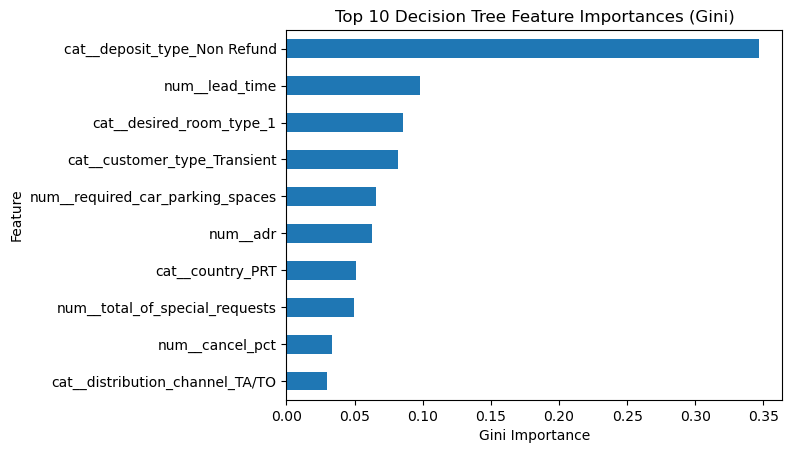

In [13]:
import pandas as pd

# Gini importance = feature_importances_
gini_imp = pd.DataFrame({
    "Feature": X_train_scaled.columns,
    "Gini Importance": best_dt.feature_importances_
}).sort_values("Gini Importance", ascending=False)

import matplotlib.pyplot as plt

gini_imp.head(10).plot(kind="barh", x="Feature", y="Gini Importance", legend=False)
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Top 10 Decision Tree Feature Importances (Gini)")
plt.gca().invert_yaxis()
plt.show()
 # top 10


##### 3.3 Threshold Tuning

In [14]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
import numpy as np

# --- Step 1: get predicted probabilities ---
y_prob = best_dt.predict_proba(X_test_scaled)[:, 1]

# --- Step 2: find a justified threshold (maximize F1 on validation or test) ---
prec, rec, thresh = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * prec * rec / (prec + rec + 1e-9)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_thresh = thresh[best_idx]

print(f"Best threshold (by F1): {best_thresh:.3f}, F1={f1_scores[best_idx]:.3f}")

# --- Step 3: apply threshold ---
y_pred_thresh = (y_prob >= best_thresh).astype(int)

# --- Step 4: confusion matrix ---
cm = confusion_matrix(y_test, y_pred_thresh)
print("\nConfusion matrix at best threshold:\n", cm)
print("\nClassification report with justified threshold:\n", classification_report(y_test, y_pred_thresh))

Best threshold (by F1): 0.512, F1=0.775

Confusion matrix at best threshold:
 [[19277  3273]
 [ 2810 10457]]

Classification report with justified threshold:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     22550
           1       0.76      0.79      0.77     13267

    accuracy                           0.83     35817
   macro avg       0.82      0.82      0.82     35817
weighted avg       0.83      0.83      0.83     35817



#### 4. Model Checking

##### 4.1 Learning Curve
Learning curve is used to evaluate how a machine learning model's performance improves with the size of the training dataset. It helps diagnose: Underfitting, Overfitting, Whether getting more data would help improve performance.
+ underfitting: training score is low, validation score is low
+ overfitting: training score is high, validation score is low
+ Model is learning well: Both scores converge and improve with more data

In [17]:
from sklearn.base import clone
def make_learning_curve(est):
    import matplotlib.pyplot as plt

    from sklearn.model_selection import learning_curve, StratifiedShuffleSplit

    train_sizes = np.linspace(0.05, 1.0, 8)
    # Compute learning curves
    sizes, train_scores, val_scores = learning_curve(
        estimator = est,
        X = X_train_scaled,
        y = y_train,
        train_sizes = train_sizes,
        cv = cv,
        scoring = 'f1',
        n_jobs = -1,
        shuffle = True,
        random_state=random_state
    )

    # Means & stds
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean,   val_std   = val_scores.mean(axis=1),   val_scores.std(axis=1)

    # Plot (one figure; no special colors/styles)
    plt.figure(figsize=(7,5))
    plt.plot(sizes, train_mean, marker="o", label="Training")
    plt.plot(sizes, val_mean,   marker="o", label="Validation")
    plt.fill_between(sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(sizes, val_mean-val_std,     val_mean+val_std,     alpha=0.2)
    plt.xlabel("Training set size")
    plt.ylabel('PR-AUC score')
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    fig = plt.gcf()
    ax = plt.gca()
    fig.tight_layout()
    plt.show()
    return None

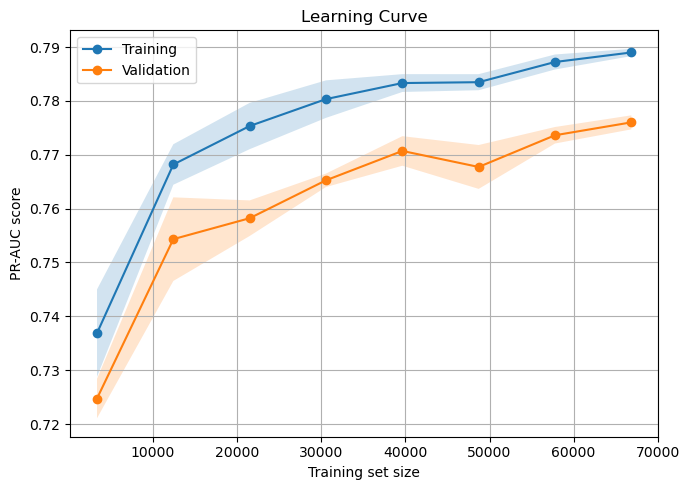

In [18]:
make_learning_curve(clone(best_dt))

##### 4.2 Validation/Model Complexity Curve
A validation/model complexity curve is a disgnostic tool used to analyze how a model's performance changes with respect to a specific hyperparameter. It helps understand if the model is underfitting or overfitting, how sensitive the model is to a particular hyperparameter, and what value of the hyperparameter gives the best generalization performance. <br>

Reading the curves:
- Overfitting - training score high, validation score low (too complex, small ccp_alpha)
- Underfitting: both scores low (too simple, large ccp_alpha)
- sweet spot: validation score peaks and is close to training score

In [19]:

def make_validation_curve(est, param_name, param_range):

    from sklearn.model_selection import  validation_curve

    # compute the validation curve
    train_scores, val_scores = validation_curve(
        estimator=est,
        X=X_train_scaled,
        y=y_train,
        param_name=param_name,
        param_range=param_range,
        scoring='average_precision',
        cv=cv,
        n_jobs=-1,
    )

    # aggregate
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    # pick best alpha (by mean validation score)
    best_idx = int(np.argmax(val_mean))
    best_alpha = float(param_range[best_idx])

    # ---- plot ----
    plt.figure(figsize=(7,5))

    # For visualization, semilog is nice; shift zero by a tiny epsilon to appear on log scale
    eps = 0.0000001
    x_plot = param_range + eps

    plt.semilogx(x_plot, train_mean, marker="o", label="Training")
    plt.semilogx(x_plot, val_mean,   marker="o", label="Validation")

    plt.fill_between(x_plot, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(x_plot, val_mean-val_std,     val_mean+val_std,     alpha=0.2)

    # vertical marker at best alpha
    plt.axvline(best_alpha + eps, linestyle="--", linewidth=1)

    plt.xlabel("ccp_alpha (log scale)")
    plt.ylabel('PR AUC Score')
    plt.title("Model-Complexity Curve: Decision Tree vs. ccp_alpha")
    plt.legend()
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()

    print(f"Suggested ccp_alpha (by CV mean F1): {best_alpha:.6g}")
    return None


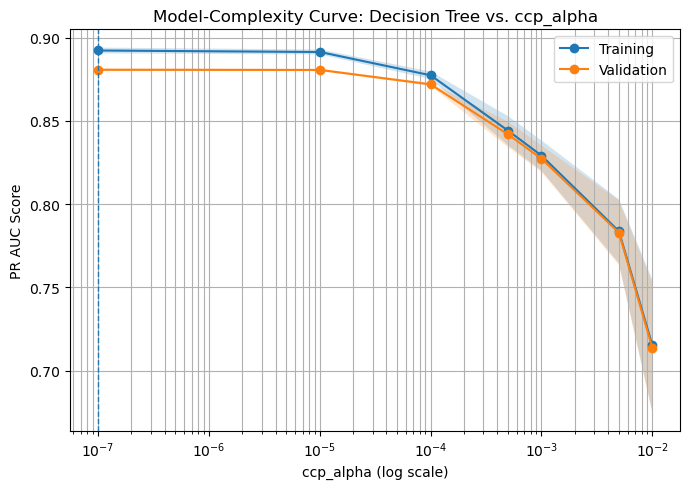

Suggested ccp_alpha (by CV mean F1): 0


In [20]:
param_name = "ccp_alpha"
param_range = np.array([0.0, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01])
make_validation_curve(clone(best_dt), param_name, param_range)